# From Data to Careers: A Subreddit Journey through r/datascience and r/jobs


---

## Part 3: Classification Modeling

---

#### Introduction

The final phase focuses on creating and comparing classification models to understand which model was best in discerning the origin of a post. The goal is to develop a robust and accurate classification system using a combination of logistic regression, Naive Bayes, and KNN. These models will not only provide insights into the distinctive characteristics of each subreddit but also serve as a valuable tool for those navigating the realms of data science and job-seeking. 


---

#### Deliverables

- Identify and explain the baseline score for the classification models.
- Provide an explanation of how the chosen model works.
- Select and use metrics that are relevant to the problem objective.
- Ensure proper splitting and/or sampling of data for validation/training purposes.
- Test and evaluate a variety of models, including at least two classification models (KNN, Naive Bayes, logistic regression)
- Evaluate the performance successes and downfalls of the model.

---

#### Imports

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

#nltk imports
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#function imports
from text_preprocessing import remove_specific_text, verify_cvec_conversion, verify_tvec_conversion

---

#### Load Data

In [194]:
df_datascience = pd.read_csv('../data/rdatascience.csv')
df_jobs = pd.read_csv('../data/rjobs.csv')

---

#### Data Preparation

In [195]:
# Custom stop words
custom_stop_words = ['ve', 'don', 'amp']

In [196]:
#Combine custom stop words with NLTK stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

In [197]:
# #Combine data and create labels (0 for r/datascience, 1 for r/jobs)

df_datascience['label'] = 0
df_jobs['label'] = 1
df_combined = pd.concat([df_datascience, df_jobs], ignore_index=True)


In [198]:
df_combined.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,preview,author_cakeday,url_overridden_by_dest,crosspost_parent_list,crosspost_parent,is_gallery,gallery_data,selftext_length,selftext_word_count,label
0,NaN,datascience,Hi I wanted to get some takes from actual sta...,t2_4ffvev5v,False,NaN,0,False,Interested in statistics not sure how to proceed,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720,139,0
1,NaN,datascience,I'm a statistician looking for work after a la...,t2_6cjiszgb,False,NaN,0,False,Create Github repository?,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,344,54,0
2,NaN,datascience,My upcoming course is focused on programming a...,t2_3puwn,False,NaN,0,False,Linear Algebra and Multivariate Calculus,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,733,122,0
3,NaN,datascience,Our company has 1000 ish headcount with 3 dist...,t2_16kgog,False,NaN,0,False,"DS org, decentralized or centralized?",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,332,58,0
4,NaN,datascience,"Hi all, I'd like to rehash my understanding of...",t2_xfx8ms4,False,NaN,0,False,Probability reference book for data science pr...,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,773,124,0


In [199]:
df_combined.shape

(1637, 119)

---

## Model Selection/Training/Evaluation

#### Model Selection

I am considering three models: Multinomial Naive Bayes, Logistic Regression, and K-Nearest Neighbors (KNN) for classification modeling. Each model has its own characteristics, and the follow section will evaluate their performance to choose the best one.

- Multinomial Naive Bayes: The reason this model is being considered is because it a good choice for classifying job-related text data.
- Logistic Regression: The reason this model is being considered is because lr is used for binary classification problem, which is suitable for the task of classifying posts into two categories.
- K-Nearest Neighbors: The reason this model is being considered is because KNN can capture similarities between posts that might be indicative of the category.

In [200]:
# #split the data in training and testing sets

X_train, X_test, y_train, y_test = train_test_split(df_combined['selftext'], 
                                                    df_combined['label'], 
                                                    test_size=0.2, 
                                                    random_state=42)


In [201]:
# Verify CountVectorizer conversion
verify_cvec_conversion(X_train)


Shape of Count Matrix: (1309, 10462)


(1309, 10462)

In [202]:
# Verify TfidfVectorizer conversion
verify_tvec_conversion(X_train)


Shape of TF-IDF Matrix: (1309, 10462)


(1309, 10462)

In [203]:
# Function to remove specific text
X_train_preprocessed = X_train.apply(remove_specific_text)
X_test_preprocessed = X_test.apply(remove_specific_text)

**Baseline Score**

In [204]:
#Baseline score
print(f"Baseline Train Score:\n {y_train.value_counts(normalize=True)}")
print(f"Baseline Test Score:\n {y_test.value_counts(normalize=True)}")

Baseline Train Score:
 label
1    0.580596
0    0.419404
Name: proportion, dtype: float64
Baseline Test Score:
 label
1    0.509146
0    0.490854
Name: proportion, dtype: float64


In [205]:
baseline_train = y_train.value_counts(normalize=True).max()
print(f"Baseline Train Score: {baseline_train:.2%}")

Baseline Train Score: 58.06%


**Interpretation:**

Class 1 represents the majority class with a proportion of approximately 58.06%, while Class 0 represents the minority class with a proportion of approximately 41.94%. When evaluating the selected classificaton model, their accuracy should be significantly higher than the baseline to justify their effectiveness.

---

#### Model Training Multinomial Naive Bayes

In [206]:
#pipeline up with two stages: 
#cvec = transformer, nb = estimator
nb_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=list(stop_words))),
    ('nb', MultinomialNB())
])

In [207]:
#Define Parameter grids for GridSearchCV
param_grid_nb = {
    'cvec__max_features': [500, 1000, 2000, 3000, 4000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.1, 0.5, 1.0]
}

In [208]:
#explore different combination of the parameters to find which one works best
grid_search_nb = GridSearchCV(nb_pipe, param_grid=param_grid_nb, cv=5, n_jobs=-1)

In [209]:
#fit the model with GridSearchCV
grid_search_nb.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['both',
                                                                    'been',
                                                                    'few',
                                                                    'doesn',
                                                                    'your',
                                                                    'amp', 'm',
                                                                    'because',
                                                                    'didn',
                                                                    'but',
                                                                    'there',
                                                                    "shan't",
                                                                    'more',
                                                                    'she',
                                                                    'couldn',
                                                                    'ourselves',
                                                                    'then',
                                                                    "needn't",
                                                                    'than',
                                                                    "doesn't",
                                                                    'its', 'ma',
                                                                    'their',
                                                                    'these',
                                                                    'nor',
                                                                    "it's",
                                                                    "that'll",
                                                                    'below',
                                                                    "isn't",
                                                                    "mustn't", ...])),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [500, 1000, 2000, 3000, 4000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'nb__alpha': [0.1, 0.5, 1.0]})


#### Model Evaluation MNB

I will use accuracy, confusion matrix, and classification report as evaluation metrics, same will apply for the other models.

In [210]:
#Print best parameters
print("Best parameters for Multinomial Naive Bayes:", grid_search_nb.best_params_)

Best parameters for Multinomial Naive Bayes: {'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'nb__alpha': 0.1}


In [211]:
#Print best scores
best_cv_score_nb = grid_search_nb.best_score_
print(f"Best Cross-Validation Score: {best_cv_score_nb:.2%}")

Best Cross-Validation Score: 91.91%


In [212]:
# Score model on training set.
train_accuracy_nb = grid_search_nb.score(X_train_preprocessed, y_train)
print(f"Training Accuracy: {train_accuracy_nb:.2%}")

Training Accuracy: 93.58%


In [213]:
# Score model on testing set.
test_accuracy_nb = grid_search_nb.score(X_test_preprocessed, y_test)
print(f"Testing Accuracy: {test_accuracy_nb:.2%}")

Testing Accuracy: 90.85%


In [214]:
best_nb_model = grid_search_nb.best_estimator_
best_nb_model

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=2000, min_df=3,
                                 ngram_range=(1, 2),
                                 stop_words=['both', 'been', 'few', 'doesn',
                                             'your', 'amp', 'm', 'because',
                                             'didn', 'but', 'there', "shan't",
                                             'more', 'she', 'couldn',
                                             'ourselves', 'then', "needn't",
                                             'than', "doesn't", 'its', 'ma',
                                             'their', 'these', 'nor', "it's",
                                             "that'll", 'below', "isn't",
                                             "mustn't", ...])),
                ('nb', MultinomialNB(alpha=0.1))])

In [215]:
#get predictions on the testing set
nb_preds = best_nb_model.predict(X_test_preprocessed)

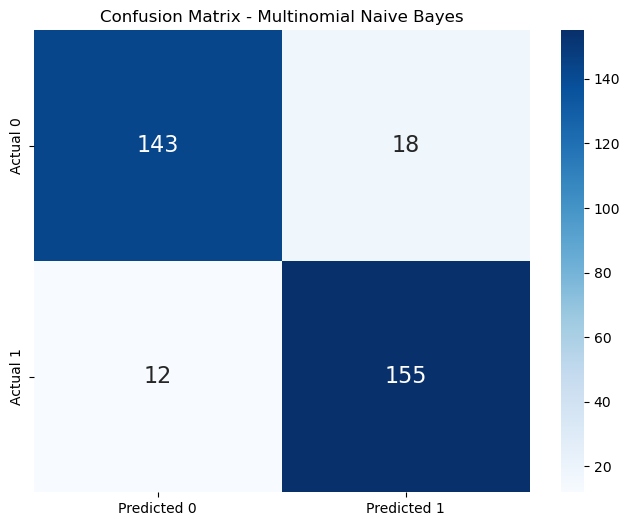

In [216]:
#confusion matrix
conf_matrix_nb = confusion_matrix(y_test, nb_preds)
#Extract confusion matrix values
tn, fp, fn, tp = conf_matrix_nb.ravel()
#Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16},
            xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.savefig('../images/confusionmatrixnb.png', bbox_inches='tight')
plt.show()

In [94]:
# Classification Report
classification_report_nb = classification_report(y_test, nb_preds)
print("Classification Report - Multinomial Naive Bayes:")
print(classification_report_nb)

Classification Report - Multinomial Naive Bayes:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       161
           1       0.90      0.93      0.91       167

    accuracy                           0.91       328
   macro avg       0.91      0.91      0.91       328
weighted avg       0.91      0.91      0.91       328



**classification report:**

- r/datascience (Class 0): Precision of 0.92 means that out of all instances predicted as r/datascience, 92% are correct. It indicates a low false positive rate.Recall of 0.89 means that out of all actual r/datascience instances, 89% were correctly predicted by the model.

- r/jobs (Class 1): Precision of 0.90 means that out of all instances predicted as r/jobs, 90% are correct. It indicates a low false positive rate. Recall of 0.93 means that out of all actual r/jobs instances, 93% were correctly predicted by the model.

**Confusion matrix**

- True Positives (155): Model correctly predicted post from r/jobs
- True Negative (143): Model correctly predicted post from r/datascience
- False Positives (18): Model incorrectly predicted posts from r/jobs when the actual subreddit was r/datascience
- False Negatives (12): Model incorrectly predicted posts from r/datascience when the actual subreddit was r/jobs

The model correctly identifies both r/datascience and r/jobs posts, demonstrating high accuracy, as evidenced by the high counts in the diagonal elements.


**Interpretation:**

- Overall, the Multinomial Naive Bayes Model with the specified hyperparameters performs well on both the training and testing. The best cross-validation accuracy achieved during the grid search was 91.91% (This is a good performance, suggesting that the model can effectively distinguish between the two subreddits). The accuracy on the training set was 93.58%, while the testing set was 91.16%. These scores suggest that the model is not overfitting. The model exhibits high precision and recall for both classes, indicating that it performs well in correctly classifying posts for both subreddits. The classification report supports the notion that the model is robust and effective in distinguishing between the two subreddits, meeting the project's objectives effectively.


---

#### Model Training Logistic Regression

In [95]:
#pipeline up with two stages: 
#cvec = transformer, logistic = estimator
lr_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=list(stop_words))),
    ('lr', LogisticRegression())
])

In [96]:
#Define Parameter grids for GridSearchCV
param_grid_lr = {
    'cvec__max_features': [5500, 6000, 6500, 7000, 8000],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [0.85, 0.9, 0.95],
    'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'lr__penalty': ['l2'],  
    'lr__C': [1.0, 10.0, 100.0],   
    'lr__solver': ['liblinear', 'lbfgs']  
}

In [97]:
#explore different combination of the parameters to find which one works best
grid_search_lr = GridSearchCV(lr_pipe, param_grid=param_grid_lr, 
                             cv=5, n_jobs=-1)

In [98]:
#fit the model with GridSearchCV
grid_search_lr.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['both',
                                                                    'been',
                                                                    'few',
                                                                    'doesn',
                                                                    'your',
                                                                    'amp', 'm',
                                                                    'because',
                                                                    'didn',
                                                                    'but',
                                                                    'there',
                                                                    "shan't",
                                                                    'more',
                                                                    'she',
                                                                    'couldn',
                                                                    'ourselves',
                                                                    'then',
                                                                    "needn't",
                                                                    'than',
                                                                    "doesn't",
                                                                    'its', 'ma',
                                                                    'their',
                                                                    'these',
                                                                    'nor',
                                                                    "it's",
                                                                    "that'll",
                                                                    'below',
                                                                    "isn't",
                                                                    "mustn't", ...])),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [5500, 6000, 6500, 7000, 8000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'lr__C': [1.0, 10.0, 100.0], 'lr__penalty': ['l2'],
                         'lr__solver': ['liblinear', 'lbfgs']})

#### Model Evaluation LR

In [99]:
#Print best parameters
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)

Best parameters for Logistic Regression: {'cvec__max_df': 0.85, 'cvec__max_features': 6500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'lr__C': 1.0, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}


In [100]:
#Print best scores
best_cv_score_lr = grid_search_lr.best_score_
print(f"Best Cross-Validation Score: {best_cv_score_lr:.2%}")

Best Cross-Validation Score: 91.75%


In [101]:
# Score model on training set.
train_accuracy_lr = grid_search_lr.score(X_train_preprocessed, y_train)
print(f"Training Accuracy: {train_accuracy_lr:.2%}")

Training Accuracy: 99.77%


In [102]:
# Score model on testing set.
test_accuracy_lr = grid_search_lr.score(X_test_preprocessed, y_test)
print(f"Testing Accuracy: {test_accuracy_lr:.2%}")

Testing Accuracy: 89.63%


In [103]:
best_lr_model = grid_search_lr.best_estimator_
best_lr_model

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.85, max_features=6500, min_df=2,
                                 ngram_range=(1, 3),
                                 stop_words=['both', 'been', 'few', 'doesn',
                                             'your', 'amp', 'm', 'because',
                                             'didn', 'but', 'there', "shan't",
                                             'more', 'she', 'couldn',
                                             'ourselves', 'then', "needn't",
                                             'than', "doesn't", 'its', 'ma',
                                             'their', 'these', 'nor', "it's",
                                             "that'll", 'below', "isn't",
                                             "mustn't", ...])),
                ('lr', LogisticRegression())])

In [104]:
#get predictions on the testing set
lr_preds = best_lr_model.predict(X_test_preprocessed)

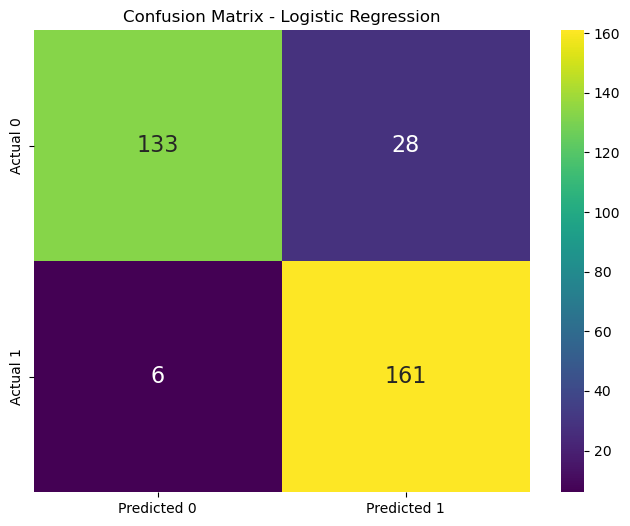

In [105]:
#confusion matrix
conf_matrix_lr = confusion_matrix(y_test, lr_preds)
#Extract confusion matrix values
tn_lr, fp_lr, fn_lr, tp_lr = conf_matrix_lr.ravel()
#Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap([[tn_lr, fp_lr], [fn_lr, tp_lr]], annot=True, fmt="d", cmap="viridis", annot_kws={"size": 16},
            xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [106]:
# Classification Report
classification_report_lr = classification_report(y_test, lr_preds)
print("Classification Report - Logistic Regression:")
print(classification_report_lr)

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       161
           1       0.85      0.96      0.90       167

    accuracy                           0.90       328
   macro avg       0.90      0.90      0.90       328
weighted avg       0.90      0.90      0.90       328



**Classification report:**

- r/datascience (Class 0): Precision of 0.96 means that out of all instances predicted as r/datascience, 96% are correct. It indicates a low false positive rate.Recall of 0.83 means that out of all actual r/datascience instances, 83% were correctly predicted by the model.

- r/jobs (Class 1): Precision of 0.85 means that out of all instances predicted as r/jobs, 85% are correct. It indicates a low false positive rate. Recall of 0.96 means that out of all actual r/jobs instances, 96% were correctly predicted by the model.

**Confusion matrix**

- True Positives (161): Model correctly predicted post from r/jobs
- True Negative (133): Model correctly predicted post from r/datascience
- False Positives (28): Model incorrectly predicted posts from r/jobs when the actual subreddit was r/datascience
- False Negatives (6): Model incorrectly predicted posts from r/datascience when the actual subreddit was r/jobs

The model correctly identifies both r/datascience and r/jobs posts, demonstrating high accuracy, as evidenced by the high counts in the diagonal elements.


**Interpretation:**

- Overall, the logistic regression model with the specified hyperparameters performs well on both the training and testing and demonstrate strong performance with high accuracy, precision, and recall. The best cross-validation accuracy achieved during the grid search was 91.75% (This is a good performance, suggesting that the model can effectively distinguish between the two subreddits). The accuracy on the training set was 99.77%, while the testing set was 89.63%. These scores suggest that the model might be overfitting to some extent. The model exhibits high precision and recall for both classes, indicating that it performs well in correctly classifying posts for both subreddits. The classification report supports the notion that the model is robust and effective in distinguishing between the two subreddits, meeting the project's objectives effectively.


---

#### Model Training K-Nearest Neighbors

In [107]:
#pipeline up with two stages: 
#cvec = transformer, knn = estimator
knn_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=list(stop_words))),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier())
])

In [108]:
#Define Parameter grids for GridSearchCV
param_grid_knn = {
    'cvec__max_features': [50, 100, 200, 300, 400, 500],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'knn__n_neighbors': [3, 5, 7]  
}

In [109]:
#explore different combination of the parameters to find which one works best
grid_search_knn = GridSearchCV(knn_pipe, param_grid=param_grid_knn, 
                             cv=5, n_jobs=-1)

In [110]:
#fit the model with GridSearchCV
grid_search_knn.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['both',
                                                                    'been',
                                                                    'few',
                                                                    'doesn',
                                                                    'your',
                                                                    'amp', 'm',
                                                                    'because',
                                                                    'didn',
                                                                    'but',
                                                                    'there',
                                                                    "shan't",
                                                                    'more',
                                                                    'she',
                                                                    'couldn',
                                                                    'ourselves',
                                                                    'then',
                                                                    "needn't",
                                                                    'than',
                                                                    "doesn't",
                                                                    'its', 'ma',
                                                                    'their',
                                                                    'these',
                                                                    'nor',
                                                                    "it's",
                                                                    "that'll",
                                                                    'below',
                                                                    "isn't",
                                                                    "mustn't", ...])),
                                       ('ss', StandardScaler(with_mean=False)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [50, 100, 200, 300, 400, 500],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'knn__n_neighbors': [3, 5, 7]})

#### Model Evaluation KNN

In [111]:
#Print best parameters
print("Best parameters for K-Nearest Neighbors (KNN):", grid_search_knn.best_params_)

Best parameters for K-Nearest Neighbors (KNN): {'cvec__max_df': 0.9, 'cvec__max_features': 200, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'knn__n_neighbors': 5}


In [112]:
#Print best scores
best_cv_score_knn = grid_search_knn.best_score_
print(f"Best Cross-Validation Score: {best_cv_score_knn:.2%}")

Best Cross-Validation Score: 74.56%


In [113]:
# Score model on training set.
train_accuracy_knn = grid_search_knn.score(X_train_preprocessed, y_train)
print(f"Training Accuracy: {train_accuracy_knn:.2%}")

Training Accuracy: 85.64%


In [114]:
# Score model on testing set.
test_accuracy_knn = grid_search_knn.score(X_test_preprocessed, y_test)
print(f"Testing Accuracy: {test_accuracy_knn:.2%}")

Testing Accuracy: 71.34%


In [115]:
best_knn_model = grid_search_knn.best_estimator_
best_knn_model

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=200, min_df=3,
                                 ngram_range=(1, 2),
                                 stop_words=['both', 'been', 'few', 'doesn',
                                             'your', 'amp', 'm', 'because',
                                             'didn', 'but', 'there', "shan't",
                                             'more', 'she', 'couldn',
                                             'ourselves', 'then', "needn't",
                                             'than', "doesn't", 'its', 'ma',
                                             'their', 'these', 'nor', "it's",
                                             "that'll", 'below', "isn't",
                                             "mustn't", ...])),
                ('ss', StandardScaler(with_mean=False)),
                ('knn', KNeighborsClassifier())])

In [116]:
# Get predictions for the test set
knn_preds = grid_search_knn.predict(X_test_preprocessed)


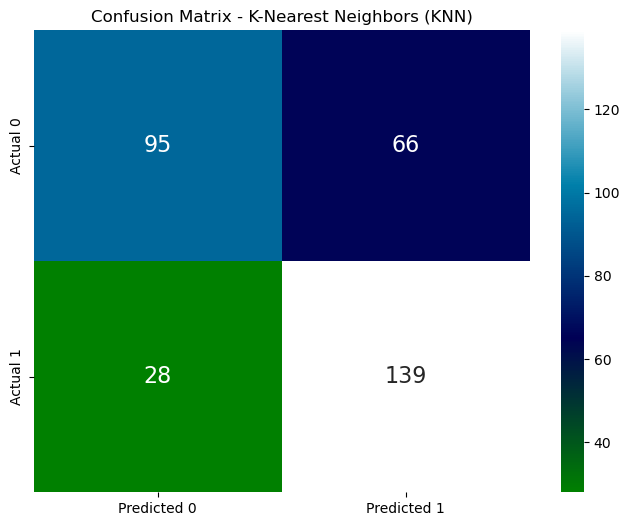

In [117]:
# Extract confusion matrix values
tn_knn, fp_knn, fn_knn, tp_knn = conf_matrix_knn.ravel()

# Confusion Matrix Visualization for KNN
plt.figure(figsize=(8, 6))
sns.heatmap([[tn_knn, fp_knn], [fn_knn, tp_knn]], annot=True, fmt="d", cmap="ocean", annot_kws={"size": 16},
            xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix - K-Nearest Neighbors (KNN)")
plt.show()

In [118]:
# Classification Report for KNN
class_report_knn = classification_report(y_test, knn_preds)
print("Classification Report for K-Nearest Neighbors (KNN):")
print(class_report_knn)

Classification Report for K-Nearest Neighbors (KNN):
              precision    recall  f1-score   support

           0       0.77      0.59      0.67       161
           1       0.68      0.83      0.75       167

    accuracy                           0.71       328
   macro avg       0.73      0.71      0.71       328
weighted avg       0.72      0.71      0.71       328



**Classification report:**

- r/datascience (Class 0): Precision of 0.77 means that out of all instances predicted as r/datascience, 77% are correct. It indicates a low false positive rate.Recall of 0.59 means that out of all actual r/datascience instances, 59% were correctly predicted by the model.

- r/jobs (Class 1): Precision of 0.68 means that out of all instances predicted as r/jobs, 68% are correct. It indicates a low false positive rate. Recall of 0.83 means that out of all actual r/jobs instances, 83% were correctly predicted by the model.

**Confusion matrix**

- True Positives (139): Model correctly predicted post from r/jobs
- True Negative (95): Model correctly predicted post from r/datascience
- False Positives (66): Model incorrectly predicted posts from r/jobs when the actual subreddit was r/datascience
- False Negatives (28): Model incorrectly predicted posts from r/datascience when the actual subreddit was r/jobs

The model correctly identifies both r/datascience and r/jobs posts, demonstrating high accuracy, as evidenced by the high counts in the diagonal elements.


**Interpretation:**

- Overall, the K-Nearest Neighbors (KNN) model with the specified hyperparameters performs better than the baseline model. Both the training and testing and demonstrate decent performance with high accuracy, precision, and recall. The best cross-validation accuracy achieved during the grid search was 74.56% (This is a decent performance, suggesting that the model can effectively distinguish between the two subreddits). The accuracy on the training set was 85.64%, while the testing set was 71.34%. These scores suggest that the model might be overfitting to some extent. The model exhibits high precision and recall for both classes, indicating that it performs well in correctly classifying posts for both subreddits. The classification report supports the notion that the model is robust and effective in distinguishing between the two subreddits, meeting the project's objectives effectively.


**Distinctive characteristics, that define an ideal data scientist for our startup, as perceived by the hiring team**

In [121]:
cvec = CountVectorizer(stop_words=list(stop_words), 
                       max_features=5000, ngram_range=(1, 2))

In [122]:
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train_preprocessed).todense(), 
                            columns=cvec.get_feature_names_out())

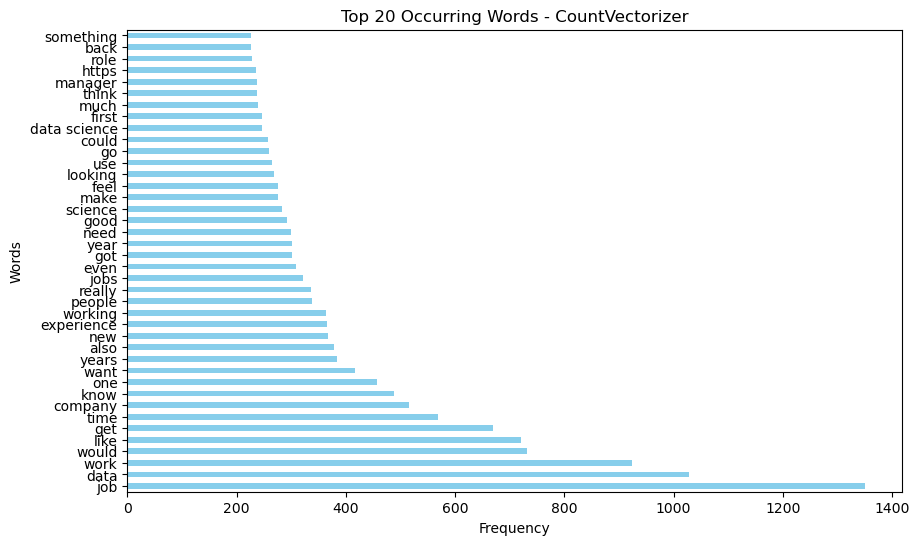

In [126]:
#combined plot of occurence words for both r/jobs and r/datascience
plt.figure(figsize=(10, 6))
X_train_cvec.sum().sort_values(ascending=False).head(20).plot(kind='barh', color='skyblue')
plt.title('Top 20 Occurring Words - CountVectorizer')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

In [186]:
# List of words hiring team wants to ommit to find Distinctive characteristics
#can be updated with more words
new_custom_stop_words = ['really', 'also', 'new', 'people', 'jobs', 'one', 'know', 'working', 'work', 'would', 
                     'like', 'get', 'could', 'go', 'something', 'back', 'role', 'even', 'looking', 'first', 
                     'make', 'think', 'use', 'feel', 'told',
                         'since', 'got', 'want', 'years', 'time', 'need',
                         'day', 'told', 'going', 'months', 
                         'position', 'pay', 'week', 'year', 'job',
                        'find', 'two', 'never', 'much', 'well', 'help', 'days', 'hours',
                         'said', 'take', 'advice', 'still', 'offer', 
                         'good', 'manager', 'interview', 'company', 'experience',
                        'anyone', 'getting', 'money', 'last', 'boss', 'things', 'school', 'start', 'lot', 'worked', 
                         'way', 'current', 'long', 'ask', 'someone', 'career', 'applied', 'next', 'degree', 'salary', 
                         'currently', 'life', 'sure', 'weeks', 'resume', 'everyone', 'home', 'right', 'another', 'interviews', 
                         'anything', 'around', 'give', 'today', 'started', 'every', 'recently', 'say', 'ago', 'better', 'using',
                         'com', 'see', 'etc', 'model', 'data', 'team', 'learning', 'science', 'great'
                        ]

In [187]:
# Separate data by subreddit
X_train_datascience = X_train_preprocessed[y_train == 0]
X_train_jobs = X_train_preprocessed[y_train == 1]

In [188]:
#CountVectorizer for r/jobs
cvec_jobs = CountVectorizer(stop_words=list(stop_words) + new_custom_stop_words, max_features=5000, ngram_range=(1, 2))
X_train_cvec_jobs = pd.DataFrame(cvec_jobs.fit_transform(X_train_jobs).todense(), 
                                        columns=cvec_jobs.get_feature_names_out())

In [178]:
# CountVectorizer for r/datascience
cvec_datascience = CountVectorizer(stop_words=list(stop_words) + new_custom_stop_words, max_features=5000, ngram_range=(1, 2))
X_train_cvec_datascience = pd.DataFrame(cvec_datascience.fit_transform(X_train_datascience).todense(), 
                                  columns=cvec_datascience.get_feature_names_out())


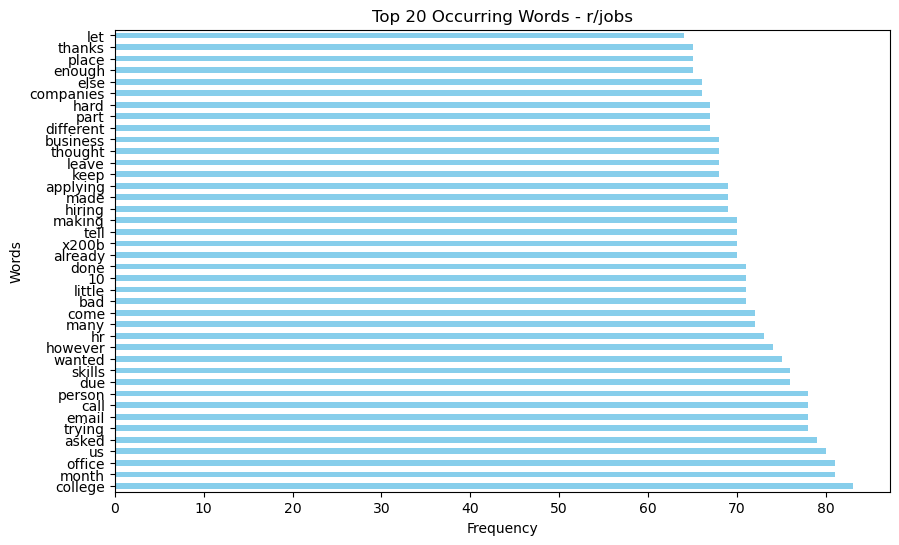

In [190]:
# top occurring words for r/jobs
plt.figure(figsize=(10, 6))
X_train_cvec_jobs.sum().sort_values(ascending=False).head(20).plot(kind='barh', color='skyblue')
plt.title('Top 20 Occurring Words - r/jobs')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

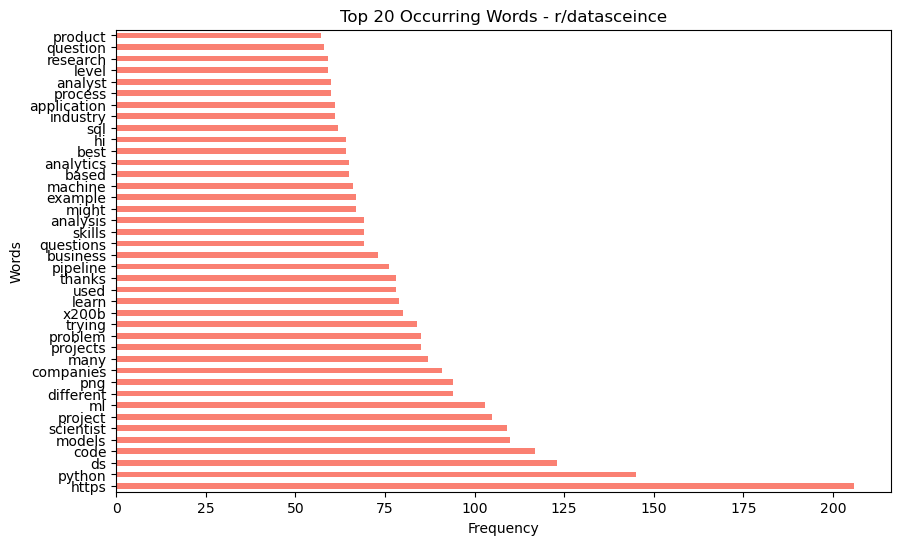

In [192]:
# top occurring words for r/datascience
plt.figure(figsize=(10, 6))
X_train_cvec_datascience.sum().sort_values(ascending=False).head(20).plot(kind='barh', color='salmon')
plt.title('Top 20 Occurring Words - r/datasceince')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()